This data was obtained from kaggle, You can downlload it from this [address](https://www.kaggle.com/datasets/amirhoseinsedaghati/the-weather-of-187-countries-in-2020)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler 
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'
%matplotlib inline

# 1. EDA

## 1.x. Data Understanding

In [3]:
weather = pd.read_csv('datasets/the weather of 187 countries in 2020.csv',
                      low_memory=False)
weather.head()

,STATION,Country/Region,DATE,Year,Month,Day,PRCP,SNWD,TAVG,TMAX,...,LONGITUDE,ELEVATION,PRCP_ATTRIBUTES,TAVG_ATTRIBUTES,TMAX_ATTRIBUTES,TMIN_ATTRIBUTES,DAPR,MDPR,WESD,SNWD_ATTRIBUTES
0,TZ000063894,Comoros,2020-01-22,2020,1,22,10.9,NaN,27.6,30.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TZ000063894,Comoros,2020-01-23,2020,1,23,0.0,NaN,26.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TZ000063894,Comoros,2020-01-24,2020,1,24,9.4,NaN,27.9,30.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TZ000063894,Comoros,2020-01-25,2020,1,25,0.3,NaN,27.9,30.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TZ000063894,Comoros,2020-01-26,2020,1,26,0.0,NaN,28.2,31.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   STATION          1048575 non-null  object 
 1   Country/Region   1048575 non-null  object 
 2   DATE             1048575 non-null  object 
 3   Year             1048575 non-null  int64  
 4   Month            1048575 non-null  int64  
 5   Day              1048575 non-null  int64  
 6   PRCP             738462 non-null   float64
 7   SNWD             214352 non-null   float64
 8   TAVG             812229 non-null   float64
 9   TMAX             666841 non-null   float64
 10  TMIN             694366 non-null   float64
 11  SNOW             103991 non-null   float64
 12  LATITUDE         102307 non-null   float64
 13  LONGITUDE        102307 non-null   float64
 14  ELEVATION        102307 non-null   float64
 15  PRCP_ATTRIBUTES  6007 non-null     object 
 16  TAVG_ATTRIBUTES  3

## 1.xx. Data Manipulation

In [ ]:
weather[weather['Country/Region'] == 'Comoros']['STATION'].unique()

In [5]:
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')

In [6]:
weather = weather.drop(['PRCP_ATTRIBUTES', 'TAVG_ATTRIBUTES', 'TMAX_ATTRIBUTES',
              'TMIN_ATTRIBUTES', 'DAPR', 'MDPR', 'WESD', 'SNWD_ATTRIBUTES'], axis=1)

In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   STATION         1048575 non-null  object        
 1   Country/Region  1048575 non-null  object        
 2   DATE            1048575 non-null  datetime64[ns]
 3   Year            1048575 non-null  int64         
 4   Month           1048575 non-null  int64         
 5   Day             1048575 non-null  int64         
 6   PRCP            738462 non-null   float64       
 7   SNWD            214352 non-null   float64       
 8   TAVG            812229 non-null   float64       
 9   TMAX            666841 non-null   float64       
 10  TMIN            694366 non-null   float64       
 11  SNOW            103991 non-null   float64       
 12  LATITUDE        102307 non-null   float64       
 13  LONGITUDE       102307 non-null   float64       
 14  ELEVATION       10

In [8]:
weather.isnull().sum()

STATION                0
Country/Region         0
DATE                   0
Year                   0
Month                  0
Day                    0
PRCP              310113
SNWD              834223
TAVG              236346
TMAX              381734
TMIN              354209
SNOW              944584
LATITUDE          946268
LONGITUDE         946268
ELEVATION         946268
dtype: int64

In [9]:
np.shape(weather['STATION'].unique())

(5152,)

In [10]:
weather.drop(['Year'], axis=1, inplace=True)

## 1.xxx. Correlation Analysis

In [12]:
weather_corr = weather.corr(numeric_only='int')
weather_corr

,Month,Day,PRCP,SNWD,TAVG,TMAX,TMIN,SNOW,LATITUDE,LONGITUDE,ELEVATION
Month,1.000000,-0.158134,0.077957,-0.291069,0.425188,0.488729,0.442944,-0.181866,-0.217623,0.483713,0.081236
Day,-0.158134,1.000000,-0.009618,-0.011764,0.007674,0.011718,0.011850,-0.026557,0.159670,-0.349309,-0.059341
PRCP,0.077957,-0.009618,1.000000,-0.032212,0.117195,0.077826,0.163642,0.278578,-0.088076,0.003058,-0.066703
SNWD,-0.291069,-0.011764,-0.032212,1.000000,-0.356621,-0.346927,-0.372310,0.247146,0.326801,-0.409252,-0.195954
TAVG,0.425188,0.007674,0.117195,-0.356621,1.000000,0.981930,0.976577,-0.213097,-0.548902,0.337894,-0.248169
TMAX,0.488729,0.011718,0.077826,-0.346927,0.981930,1.000000,0.926774,-0.219229,-0.518515,0.450728,-0.150353
TMIN,0.442944,0.011850,0.163642,-0.372310,0.976577,0.926774,1.000000,-0.178355,-0.523574,0.314616,-0.278596
SNOW,-0.181866,-0.026557,0.278578,0.247146,-0.213097,-0.219229,-0.178355,1.000000,0.092462,-0.029143,0.059421
LATITUDE,-0.217623,0.159670,-0.088076,0.326801,-0.548902,-0.518515,-0.523574,0.092462,1.000000,-0.391579,-0.130990
LONGITUDE,0.483713,-0.349309,0.003058,-0.409252,0.337894,0.450728,0.314616,-0.029143,-0.391579,1.000000,0.137877


## 1.xxxx. Data Visualization

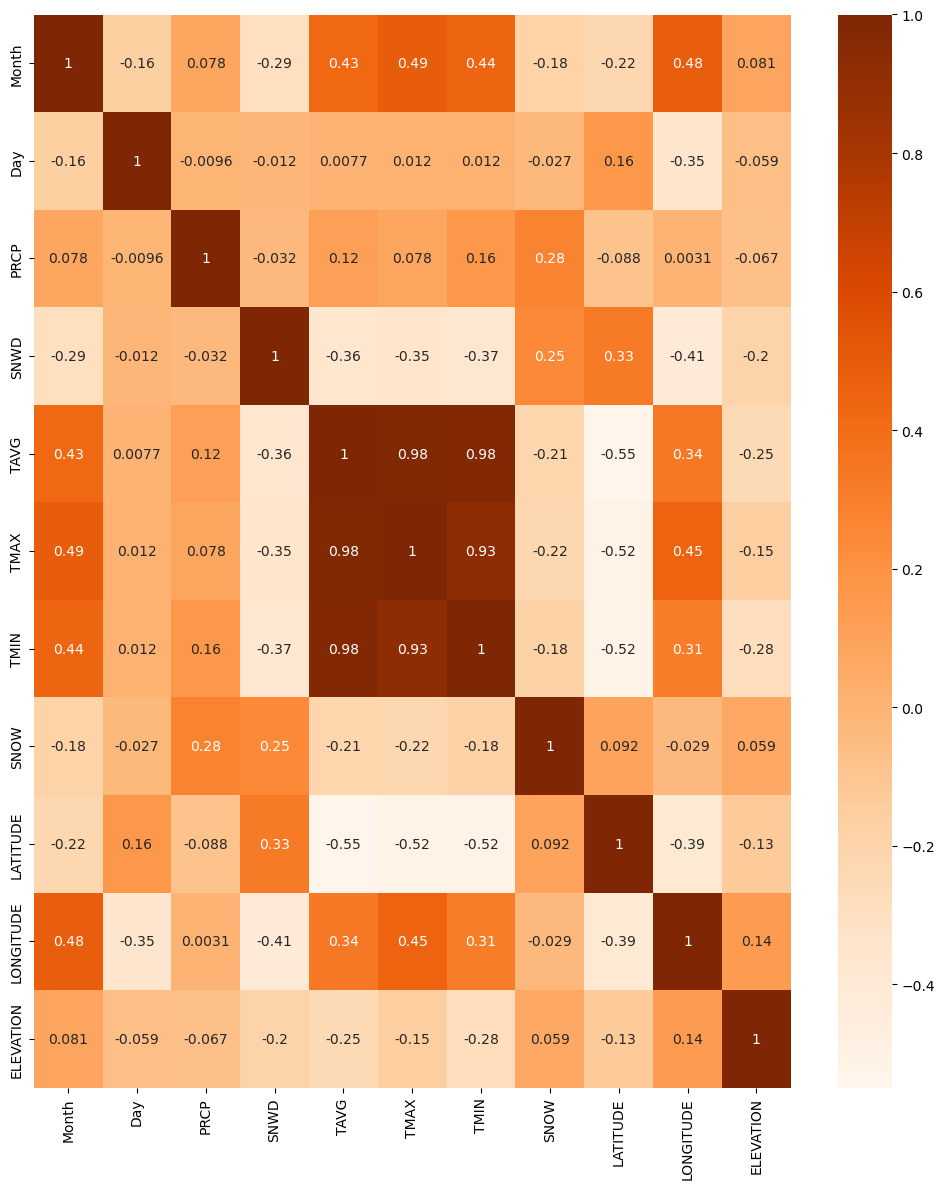

In [13]:
plt.figure(figsize=(10, 12))
sns.heatmap(weather_corr, annot=True, cmap='Oranges');
plt.tight_layout()

In [56]:
weather.head()

,STATION,Country/Region,DATE,Month,Day,PRCP,SNWD,TAVG,TMAX,TMIN,SNOW,LATITUDE,LONGITUDE,ELEVATION
0,TZ000063894,Comoros,2020-01-22,1,22,10.9,NaN,27.6,30.2,24.9,NaN,NaN,NaN,NaN
1,TZ000063894,Comoros,2020-01-23,1,23,0.0,NaN,26.7,NaN,NaN,NaN,NaN,NaN,NaN
2,TZ000063894,Comoros,2020-01-24,1,24,9.4,NaN,27.9,30.6,25.6,NaN,NaN,NaN,NaN
3,TZ000063894,Comoros,2020-01-25,1,25,0.3,NaN,27.9,30.2,16.3,NaN,NaN,NaN,NaN
4,TZ000063894,Comoros,2020-01-26,1,26,0.0,NaN,28.2,31.5,NaN,NaN,NaN,NaN,NaN


In [11]:
weather_copy = weather.copy()
weather_copy.set_index('DATE', inplace=True)
weather_seasonal = weather_copy.resample('M').mean(numeric_only=True)[['TAVG', 'TMAX', 'TMIN']]
weather_seasonal_df = pd.DataFrame(weather_seasonal)
px.histogram(weather_seasonal_df, x=weather_seasonal_df.index, y='TAVG',
             color='TAVG', nbins=7, title='The sum of TAVG Monthly')

In [12]:
px.histogram(weather_seasonal_df, x=weather_seasonal_df.index, y='TMAX',
             color='TMAX', nbins=7, title='The sum of TMAX Monthly')

In [13]:
px.histogram(weather_seasonal_df, x=weather_seasonal_df.index, y='TMIN',
             color='TMIN', nbins=7, title='The sum of TMIN Monthly')

In [14]:
min_trace = go.Bar(
    x= weather_seasonal_df.index,
    y= weather_seasonal_df['TMIN'],
    name='TMIN')

avg_trace = go.Bar(
    x= weather_seasonal_df.index,
    y= weather_seasonal_df['TAVG'],
    name='TAVG')

max_trace = go.Bar(
    x= weather_seasonal_df.index,
    y= weather_seasonal_df['TMAX'],
    name='TMAX')

layout = go.Layout(title='The sum of Temperatures Monthly',
                   barmode='stack')

fig = go.Figure(data=[min_trace, avg_trace, max_trace], layout=layout)
fig.show()

# 2. Data Preprocessing

## 2.x. Data Manipulation

In [15]:
weather = weather.drop(['STATION', 'DATE'], axis=1)

In [16]:
weather.dtypes

Country/Region     object
Month               int64
Day                 int64
PRCP              float64
SNWD              float64
TAVG              float64
TMAX              float64
TMIN              float64
SNOW              float64
LATITUDE          float64
LONGITUDE         float64
ELEVATION         float64
dtype: object

## 2.xx. Data Transformation

In [17]:
le = LabelEncoder()
weather['Country/Region'] = le.fit_transform(weather['Country/Region'])

In [18]:
weather = weather.fillna(weather.mean())

In [19]:
weather.isnull().sum()

Country/Region    0
Month             0
Day               0
PRCP              0
SNWD              0
TAVG              0
TMAX              0
TMIN              0
SNOW              0
LATITUDE          0
LONGITUDE         0
ELEVATION         0
dtype: int64

In [20]:
y = weather['TMAX'].values
weather.drop('TMAX', axis=1, inplace=True)

In [21]:
np.isnan(y).sum()

0

In [22]:
ct = ColumnTransformer(transformers=[('Country', OneHotEncoder(), [0])], remainder='passthrough')
X = ct.fit_transform(weather).todense()

In [23]:
mms = MinMaxScaler(feature_range=(0, 1))
X = mms.fit_transform(np.asarray(X))

# 3. Data Modeling

In [24]:
X = csr_matrix(np.asarray(X))
X

<1048575x165 sparse matrix of type '<class 'numpy.float64'>'
	with 10793555 stored elements in Compressed Sparse Row format>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [26]:
gboost_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000, max_depth=3, max_features=.8,
                                       subsample=1, criterion='friedman_mse', loss='squared_error',
                                       learning_rate=0.1, verbose=0)
gboost_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_features=0.8, n_estimators=1000, random_state=0,
                          subsample=1)

In [27]:
data_matrix = xgb.DMatrix(data=X, label=y)

In [28]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, max_depth=3, colsample_bytree=.8,
                          learning_rate=0.1, random_state=0, subsample=1, n_jobs=-1, eval_metric='mae',
                          verbosity=0)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [29]:
catb_reg = CatBoostRegressor(loss_function='RMSE', iterations=10000, depth=3, colsample_bylevel=1,
                             eval_metric='MAE', subsample=1, random_state=0, verbose=0, eta=.1)
catb_reg.fit(X_train, y_train, cat_features=None)

# 4. Data Evaluation

In [30]:
print(np.mean(y))
print(np.std(y))

17.81944201591283
10.7602451851612


In [31]:
predicted = gboost_reg.predict(X_test)

In [32]:
print(mean_absolute_error(y_true=y_test, y_pred=predicted))
print(mean_squared_error(y_true=y_test, y_pred=predicted))

2.8075817273024195
18.436525699034373


In [33]:
print('R-Squared Score (Training) : {}'.format(r2_score(y_train, y_pred=gboost_reg.predict(X_train))))
print('R-Squared Score (Test) : {}'.format(r2_score(y_true=y_test, y_pred=predicted)))

R-Squared Score (Training) : 0.8433541301618446
R-Squared Score (Test) : 0.8406007292467028


In [34]:
predicted = xgb_reg.predict(X_test)

In [35]:
print(mean_absolute_error(y_true=y_test, y_pred=predicted))
print(mean_squared_error(y_true=y_test, y_pred=predicted))

2.3495707296683856
15.968267683569493


In [36]:
print('R-Squared Score (Training) : {}'.format(r2_score(y_train, y_pred=xgb_reg.predict(X_train))))
print('R-Squared Score (Test) : {}'.format(r2_score(y_true=y_test, y_pred=predicted)))

R-Squared Score (Training) : 0.8741520643497916
R-Squared Score (Test) : 0.8619408957248527


In [37]:
predicted = catb_reg.predict(X_test)

In [38]:
print(mean_absolute_error(y_true=y_test, y_pred=predicted))
print(mean_squared_error(y_true=y_test, y_pred=predicted))

2.4032757583639346
16.256068792483724


In [39]:
print('R-Squared Score (Training) : {}'.format(r2_score(y_train, y_pred=catb_reg.predict(X_train))))
print('R-Squared Score (Test) : {}'.format(r2_score(y_true=y_test, y_pred=predicted)))

R-Squared Score (Training) : 0.8646072961242905
R-Squared Score (Test) : 0.8594526130824609
